In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
import warnings
warnings.filterwarnings('ignore')

# Вспомогательные классы и функции

In [2]:
# Кастомный класс для загрузки датасета с изображениями
class MyDataset(Dataset):
    def __init__(self, root, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.all_files = []
        self.all_labels = []
        self.images = []
        self.classes = sorted(os.listdir(self.root))
        for i, class_name in enumerate(self.classes):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            self.all_files += files
            self.all_labels += [i] * len(files)
            if self.load_to_ram:
                self.images += self._load_images(files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]
        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
# функция для построения графиков loss'a и accuracy на train и test
def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='validation')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='validation')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


# функция для обучения модели и расчета точности на train
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc, to_device=True):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        if to_device:
            images = images.to(device)
            labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(images) 
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


# функция для расчета точности на валидации
@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc, to_device=True):
    val_loss, val_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        if to_device:
            images = images.to(device) 
            labels = labels.to(device)  
        logits = model(images)
        loss = criterion(logits, labels)

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    return val_loss, val_accuracy


# глобальная функция для обучения модели и отрисовки графиков для train и validation
def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, save=False, to_device=True):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_validation = 0.0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}',
            to_device=to_device
        )
        val_loss, val_accuracy = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}',
            to_device=to_device
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]
        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)
        
        if save and val_accuracies[-1] > best_validation:
            best_validation = val_accuracies[-1]
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }, f'{save}.pt')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [4]:
# для расчета на GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
transform_cnn = T.Compose([
    #T.RandomHorizontalFlip(p=0.4),
    #T.RandomVerticalFlip(p=0.4),
    T.Resize((224, 224)),
    #T.RandomCrop(224*3//4),
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [6]:
# Реализация варианта сверточной нейронной сети
class FruitConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(  # (3, 224, 224)
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # (16, 224, 224)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # (16, 112, 112)
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  #  (32, 112, 112)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # (32, 56, 56)
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (64, 56, 56)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # (64, 28, 28)
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (128, 28, 28)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # (128, 14, 14)
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # (256, 14, 14)
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),
        )
        self.classifier = torch.nn.Linear(in_features=256, out_features=100)

    def forward(self, x):  # (B, 3, 224, 224)
        feature_map = self.net(x)  
        feature_vector = feature_map.mean(dim=(2, 3))  # (B, 256)
        logits = self.classifier(feature_vector)  # (B, 100)
        return logits

In [7]:
train_dataset = MyDataset(root=r'.\fruits100\train', load_to_ram=0, transform=transform_cnn)
val_dataset = MyDataset(root=r'.\fruits100\val', load_to_ram=0, transform=transform_cnn)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=40, drop_last=True, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=10, drop_last=True, shuffle=True, pin_memory=True, num_workers=0)

# Сверточная нейронная сеть

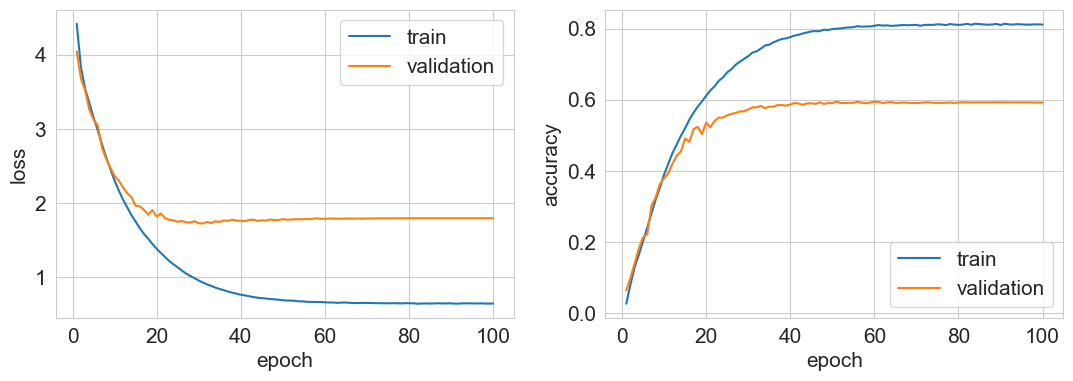

In [9]:
num_epochs = 100
model = FruitConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, 'fruit_cnn_long_calc'
)

# Mobile ImageNet со случайными весами

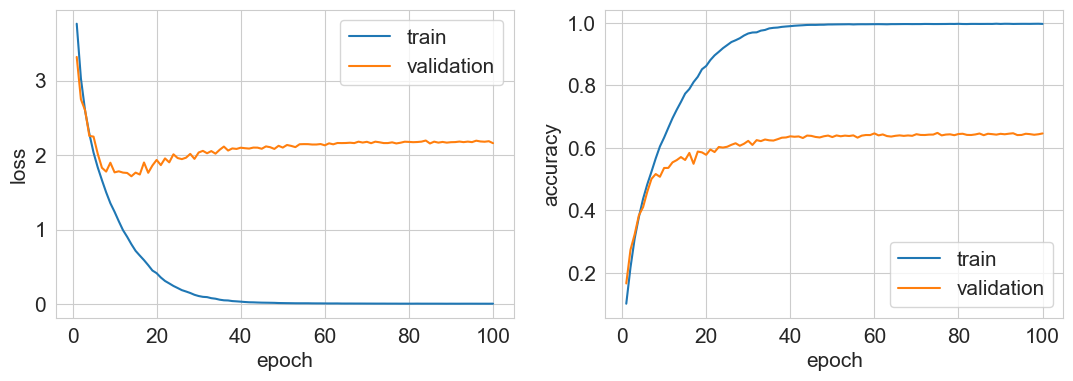

In [10]:
num_epochs = 100
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, 'fruit_mobilenet_long_calc', to_device=1
)

# Предобученный Mobile ImageNet

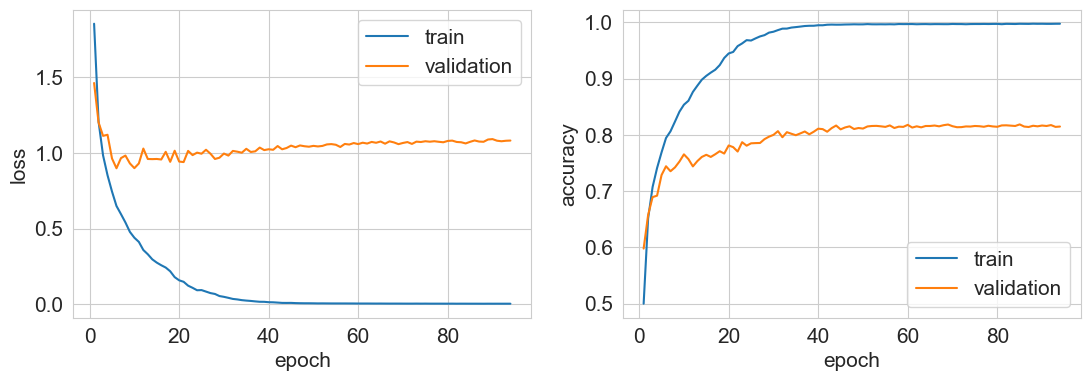

Training 95/100:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
num_epochs = 100
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, save='fruit_mobilenet_w_long_calc'
)